In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import PDI.filtros.frecuencia as freq
import PDI.filtros.espacial as espc
import PDI.utils.utils as utils
import PDI.color.color as color
import PDI.histograma.histo as histo

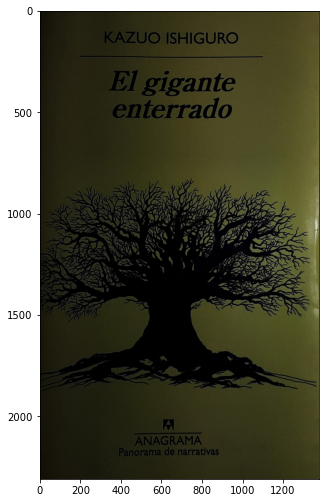

In [2]:
img = cv.imread("Imagenes/libro5.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(5,10))
plt.imshow(img);

1- Obtener canales HSV  
2- Filtrado homomorfico al V  
3- Ecualizado local  
4- Transformación gamma/potencia/LUT  
5- Algún filtrado para reducción de ruido  
6- Volver a RGB

### 1- CANALES HSV

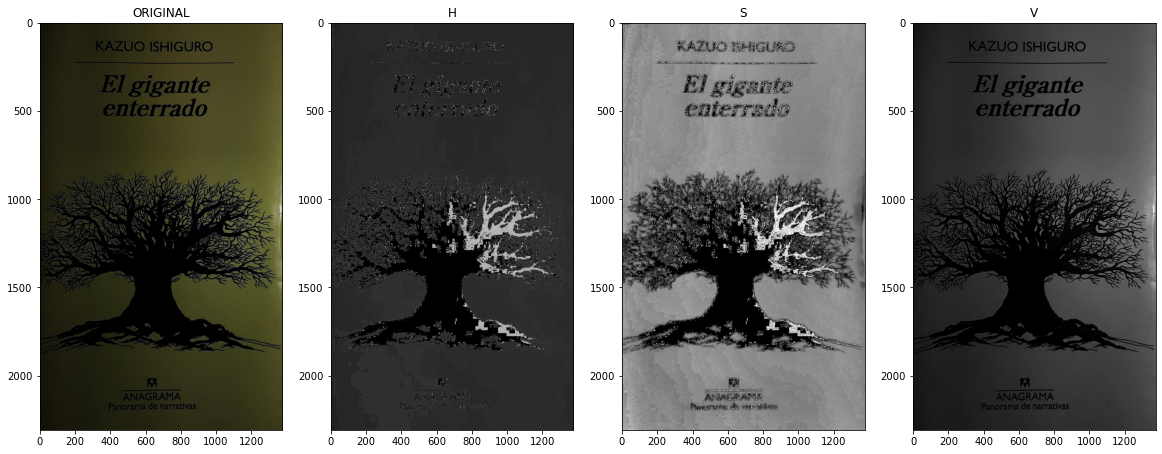

In [3]:
color.plot_color_channels(img, space='hsv')

In [49]:
channels_hsv = cv.split(color.RGB2HSV(img))

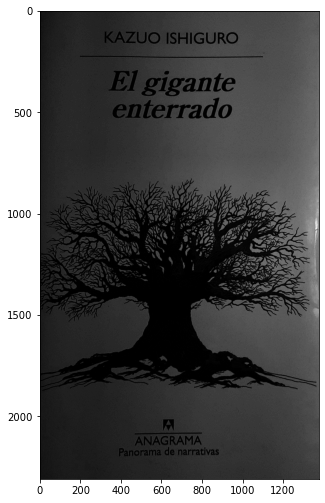

In [50]:
channel_v = channels_hsv[2]
plt.figure(figsize=(5,10))
plt.imshow(channel_v.astype('uint8'), cmap='gray')

### 2- FILTRADO HOMOMORFICO

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

In [7]:
def update_hm(low,high,fc,n):
    channel_v_hm, filtro_hm = freq.aplicar_homomorfico(channel_v, low, high, fc, n)
    
    channel_v_hm = channel_v_hm.astype('uint8')
    filtro_hm = filtro_hm.astype('uint8')
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.imshow(filtro_hm, cmap='gray')

    plt.subplot(1,3,2)
    H = low + ((high-low) / (1 + (fc/np.arange(255))**(2*n)))
    plt.plot(np.arange(255), H);

    plt.subplot(1,3,3)
    plt.imshow(channel_v_hm, cmap='gray')

interact(update_hm,
        low=widgets.IntSlider(min=-20, max=20, step=1, value=20),
        high=widgets.IntSlider(min=-20, max=20, step=1, value=4),
        fc=widgets.IntSlider(min=0, max=255, step=1, value=80),
        n=widgets.IntSlider(min=0, max=10, step=1, value=1)
    );

interactive(children=(IntSlider(value=20, description='low', max=20, min=-20), IntSlider(value=4, description=…

In [52]:
channel_v_hm, filtro_hm = freq.aplicar_homomorfico(channel_v, 20, 4, 80, 1)

### 3- ECUALIZADO LOCAL

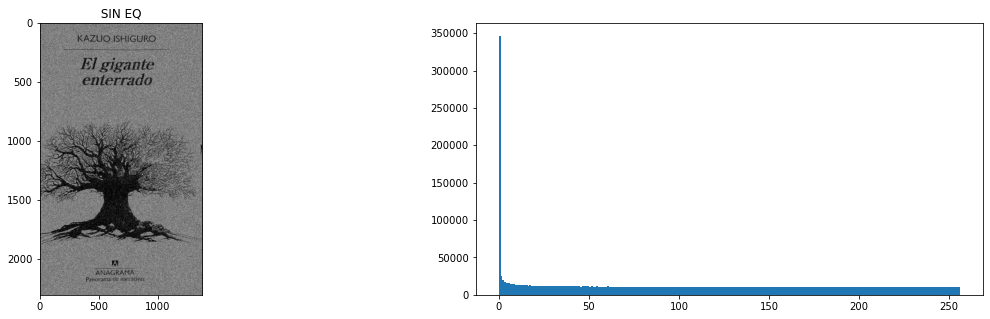

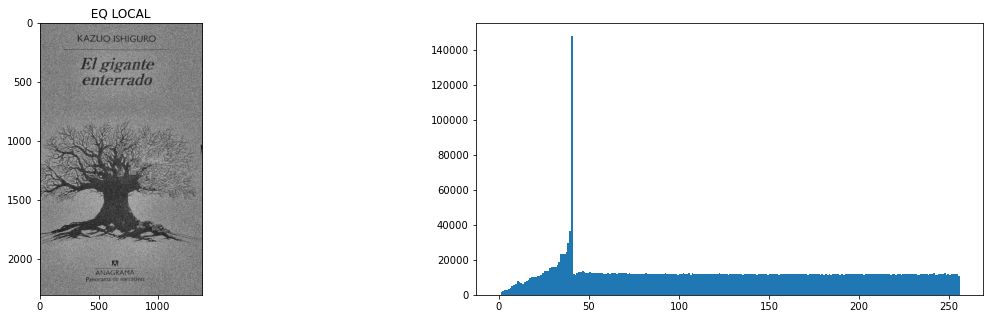

In [53]:
histo.plot_histo([channel_v_hm.astype('uint8')], figsize=(20,5), patron=(1,2), titulos=[' SIN EQ ', ''])
histo.plot_histo([channel_v_hm.astype('uint8')], eq='local', figsize=(20,5), patron=(1,2), titulos=[' EQ LOCAL ', ''])

In [54]:
channel_v_hm_eq = histo.eq_local(channel_v_hm.astype('uint8'))

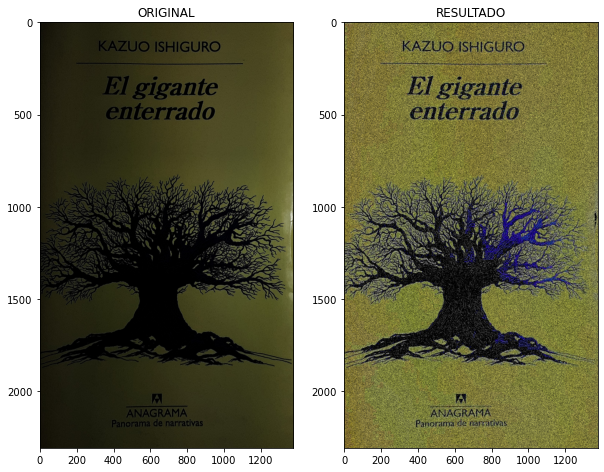

In [76]:
resultado_rgb = color.HSV2RGB(cv.merge([channels_hsv[0], channels_hsv[1], channel_v_hm.astype('uint8')]))
utils.plot([img, resultado_rgb], figsize=(10,10), patron=(1,2), gray=False, titulos=['ORIGINAL', 'RESULTADO'])

### 4- TRANSFORMACIONES

In [55]:
def update_t(gamma, c):
    t = utils.t_pot(gamma, c)
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,3,1)
    plt.imshow(channel_v_hm_eq.astype('uint8'), cmap='gray')
    
    plt.subplot(1,3,2)
    plt.plot(np.arange(255), t[np.arange(255)])
    
    plt.subplot(1,3,3)
    plt.imshow(t[channel_v_hm_eq.astype('uint8')].astype('uint8'), cmap='gray')
    
interact(update_t, 
         gamma=widgets.FloatSlider(min=0, max=10, step=.1, value=.5),
         c=widgets.FloatSlider(min=0, max=10, step=.1, value=.3)
    );

interactive(children=(FloatSlider(value=0.5, description='gamma', max=10.0), FloatSlider(value=0.3, descriptio…

In [56]:
t_gamma = utils.t_pot(.5, .3)
channel_v_gamma = t_gamma[channel_v_hm_eq]

In [65]:
channel_s_gamma = t_gamma[channels_hsv[1]]
channel_s_gamma /= np.max(channel_s_gamma)
channel_s_gamma *= 255

### 5- REDUCCION DE RUIDO

In [168]:
channel_v_espectro = freq.get_espectro(channel_v_gamma)

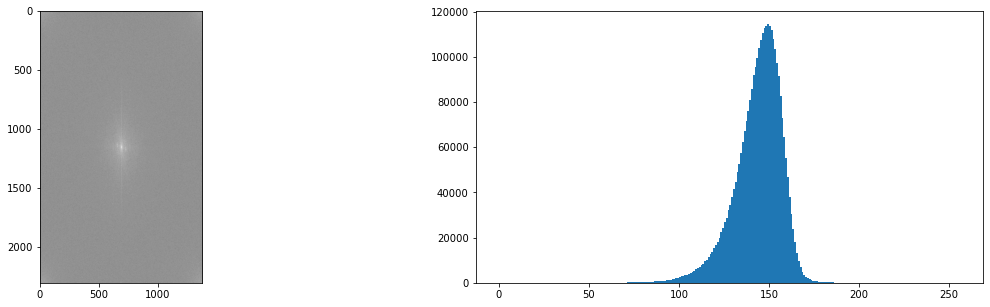

In [170]:
histo.plot_histo([channel_v_espectro.astype('uint8')])

In [65]:
def filtro_uniforme(img, tam_kernel):
    img_modified=np.copy(img)
    img_modified=cv.blur(img_modified,(tam_kernel,tam_kernel))
    return img_modified

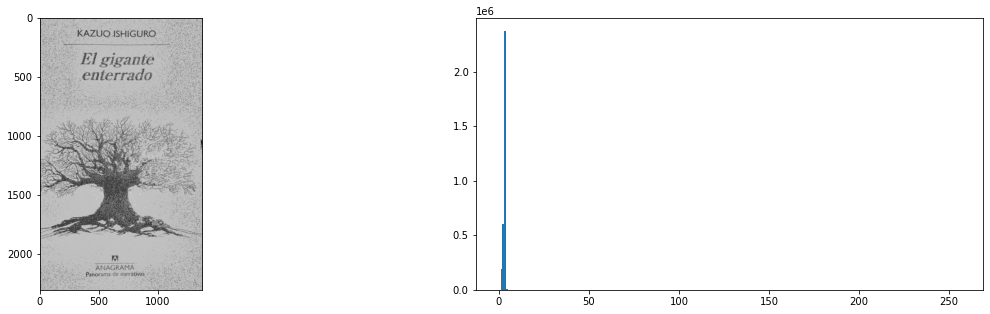

In [171]:
histo.plot_histo([filtro_uniforme(channel_v_gamma.astype('uint8'), 5).astype('uint8')])

In [58]:
def filtro_gaussiano_PB(img, tam_kernel, mu, sigmaX=0, sigmaY=0):
    img_modified=np.copy(img)
    img_modified=cv.GaussianBlur(img_modified,(tam_kernel,tam_kernel), mu,sigmaX,sigmaY)
    return img_modified

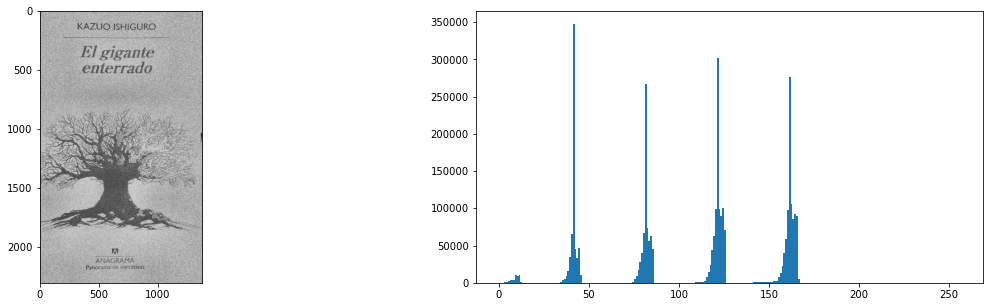

In [70]:
channel_v_gaussPB = filtro_gaussiano_PB(channel_v_gamma, 3, .1, sigmaX=.1, sigmaY=.1)
histo.plot_histo([channel_v_gaussPB.astype('uint8')], eq='local')

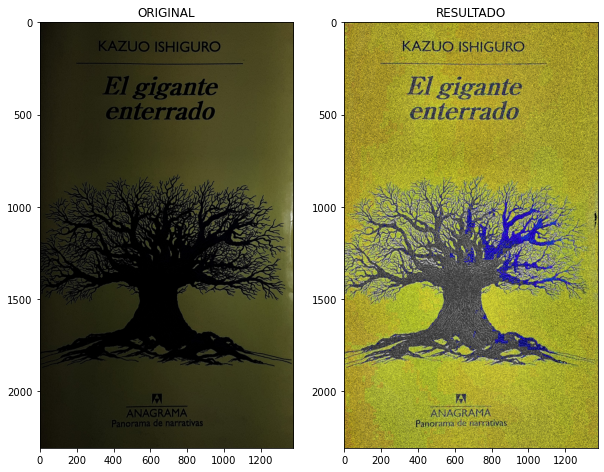

In [72]:
resultado_rgb = color.HSV2RGB(cv.merge([channels_hsv[0], channel_s_gamma.astype('uint8'), histo.eq_global(channel_v_gaussPB.astype('uint8'))]))
utils.plot([img, resultado_rgb], figsize=(10,10), patron=(1,2), gray=False, titulos=['ORIGINAL', 'RESULTADO'])

In [92]:
def filtro_MediaGeometrica(img, tam_kernel):
    img_modified=np.copy(img).astype(np.float32)
    
    (s, t) = img_modified.shape
    for i in range(0, s-tam_kernel+1):
        for j in range(0, t-tam_kernel+1):
            acum = 1
            for k in range(i, i+tam_kernel):
                for o in range(j, j+tam_kernel):
                    acum = acum * img_modified[k, o]
            img_modified[i,j] = float(pow(acum, 1.0/(tam_kernel*tam_kernel)))
    return img_modified

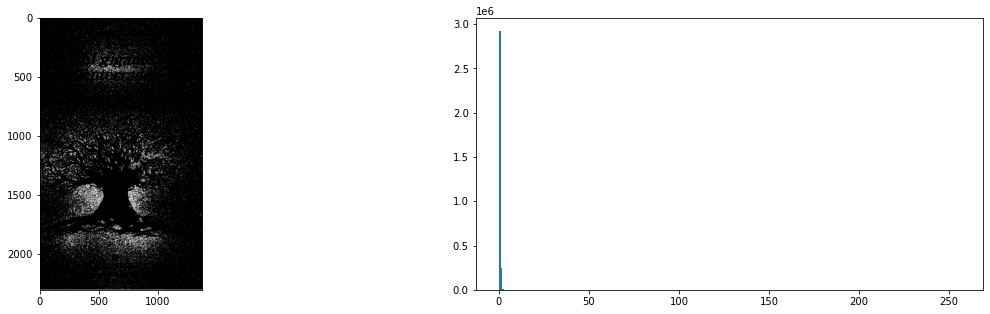

In [103]:
histo.plot_histo([filtro_MediaGeometrica(channel_v_gamma, 5)])

In [101]:
def filtro_puntoMedio(img,tam_kernel):
    img_modified = np.copy(img).astype(np.float)
    p_medio = np.int(np.ceil(tam_kernel/2))
    H,W=img.shape
    
    for i in range(0,H-tam_kernel+1):
        for j in range(0,W-tam_kernel+1):
            sub_img=img[i:i+tam_kernel,j:j+tam_kernel]
            maximo = np.max(sub_img)
            minimo = np.min(sub_img)
            img_modified[i+p_medio,j+p_medio] = 0.5*(minimo+maximo)
    return img_modified

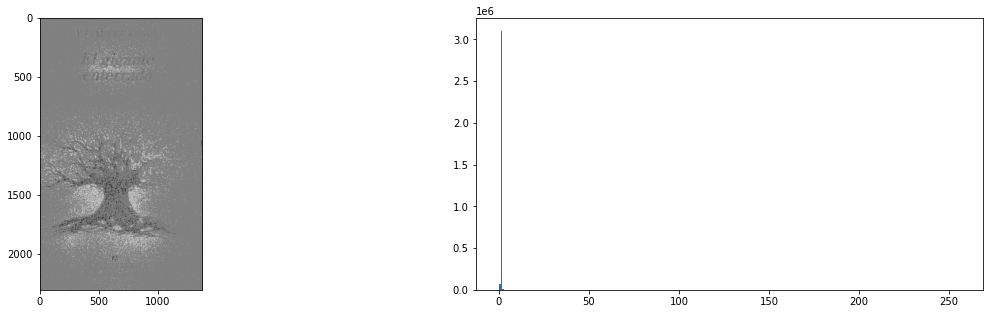

In [102]:
histo.plot_histo([filtro_puntoMedio(channel_v_gamma, 5)])